# DS Salary Prediction
- Predict salary of data scientist related role

Dataset Source : https://www.kaggle.com/datasets/saurabhbadole/latest-data-science-job-salaries-2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to get data
import os
import kagglehub
import shutil

D:\anaconda3\envs\py310_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)

D:\anaconda3\envs\py310_env\python.exe


In [3]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


## 1. Get Data

In [4]:
DATA_LOCAL_PATH = os.path.join("datasets", "salaries")
DATA_URL = "sazidthe1/data-science-salaries"

In [6]:
def download_kaggle_dataset(dataset_name=DATA_URL, local_path=DATA_LOCAL_PATH, force=False):
    """
    Downloads a Kaggle dataset to a specified local path.

    Parameters:
    - dataset_name (str): The Kaggle dataset identifier (e.g., "saurabhbadole/latest-data-science-job-salaries-2024").
    - local_path (str): The local directory to save the dataset.
    - fprce (boolean): if True, it will overwrite existing datasets
    """
    if not os.path.exists(local_path):
        os.makedirs(local_path) 
    else:
        print('Datasets already exists')
        return
    
    if force == True:
        shutil.rmtree(local_path) 
    
    cache_path = kagglehub.dataset_download(dataset_name)
    shutil.move(cache_path, local_path)
    
    
download_kaggle_dataset()

100%|██████████████████████████████████████████████████████████████████████████████| 57.3k/57.3k [00:00<00:00, 687kB/s]

Extracting files...


In [10]:
def load_salaries_data(salaries_path=DATA_LOCAL_PATH):
    csv_path = os.path.join(salaries_path, "2", "data_science_salaries.csv")
    
    return pd.read_csv(csv_path)

In [11]:
ds_jobs = load_salaries_data()
ds_jobs.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


In [12]:
ds_jobs['experience_level'] = ds_jobs['experience_level'].replace({'Entry-level': 'EN', 'Mid-level': 'MI', 'Senior-level': 'SE', 'Executive-level': 'EX'})
ds_jobs['employment_type'] = ds_jobs['employment_type'].replace({'Full-time': 'FT', 'Contract': 'CT', 'Part-time': 'PT', 'Freelance': 'FL'})
ds_jobs['company_size'] = ds_jobs['company_size'].replace({'Small': 'S', 'Medium': 'M', 'Large': 'L'})
ds_jobs['company_location'] = ds_jobs['company_location'].replace({'United States': 'US'})
ds_jobs['employee_residence'] = ds_jobs['employee_residence'].replace({'United States': 'US'})
ds_jobs['remote_ratio'] = ds_jobs['work_models'].replace({'On-site': 0, 'Remote': 100, 'Hybrid': 50})

C:\Users\Asus\AppData\Local\Temp\ipykernel_14348\990045199.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ds_jobs['remote_ratio'] = ds_jobs['work_models'].replace({'On-site': 0, 'Remote': 100, 'Hybrid': 50})


In [13]:
ds_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   salary              6599 non-null   int64 
 7   salary_currency     6599 non-null   object
 8   salary_in_usd       6599 non-null   int64 
 9   company_location    6599 non-null   object
 10  company_size        6599 non-null   object
 11  remote_ratio        6599 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 618.8+ KB


This data science salaries dataset by 2025 have 93597 rows, relatively large for a dataset. We will figure out how to handle this.

The data has no missing values, 4 int attributes, and the rest is object.

In [14]:
# look at object values
obj_cols = ds_jobs.select_dtypes(include='O').columns

for col in obj_cols:
    print(ds_jobs[col].value_counts(), '\n')

job_title
Data Engineer                      1307
Data Scientist                     1243
Data Analyst                        910
Machine Learning Engineer           629
Analytics Engineer                  246
                                   ... 
Data Science Tech Lead                1
Staff Machine Learning Engineer       1
Cloud Data Architect                  1
Marketing Data Engineer               1
Sales Data Analyst                    1
Name: count, Length: 132, dtype: int64 

experience_level
SE    4105
MI    1675
EN     565
EX     254
Name: count, dtype: int64 

employment_type
FT    6552
CT      19
PT      16
FL      12
Name: count, dtype: int64 

work_models
On-site    3813
Remote     2561
Hybrid      225
Name: count, dtype: int64 

employee_residence
US                5305
United Kingdom     401
Canada             241
Germany             71
India               70
                  ... 
Serbia               1
Jersey               1
American Samoa       1
Mauritius         

In [15]:
ds_jobs.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,6599.000000,6.599000e+03,6599.000000,6599.000000
mean,2022.818457,1.792833e+05,145560.558569,40.513714
std,0.674809,5.263722e+05,70946.838070,48.219524
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,9.600000e+04,95000.000000,0.000000
50%,2023.000000,1.400000e+05,138666.000000,0.000000
75%,2023.000000,1.875000e+05,185000.000000,100.000000
max,2024.000000,3.040000e+07,750000.000000,100.000000


In [16]:
ds_jobs.remote_ratio.value_counts()

remote_ratio
0      3813
100    2561
50      225
Name: count, dtype: int64

remote_ratio looks more like object attribute rather than numerical. So we will convert that to object types.

array([[<Axes: title={'center': 'work_year'}>,
        <Axes: title={'center': 'salary'}>],
       [<Axes: title={'center': 'salary_in_usd'}>,
        <Axes: title={'center': 'remote_ratio'}>]], dtype=object)

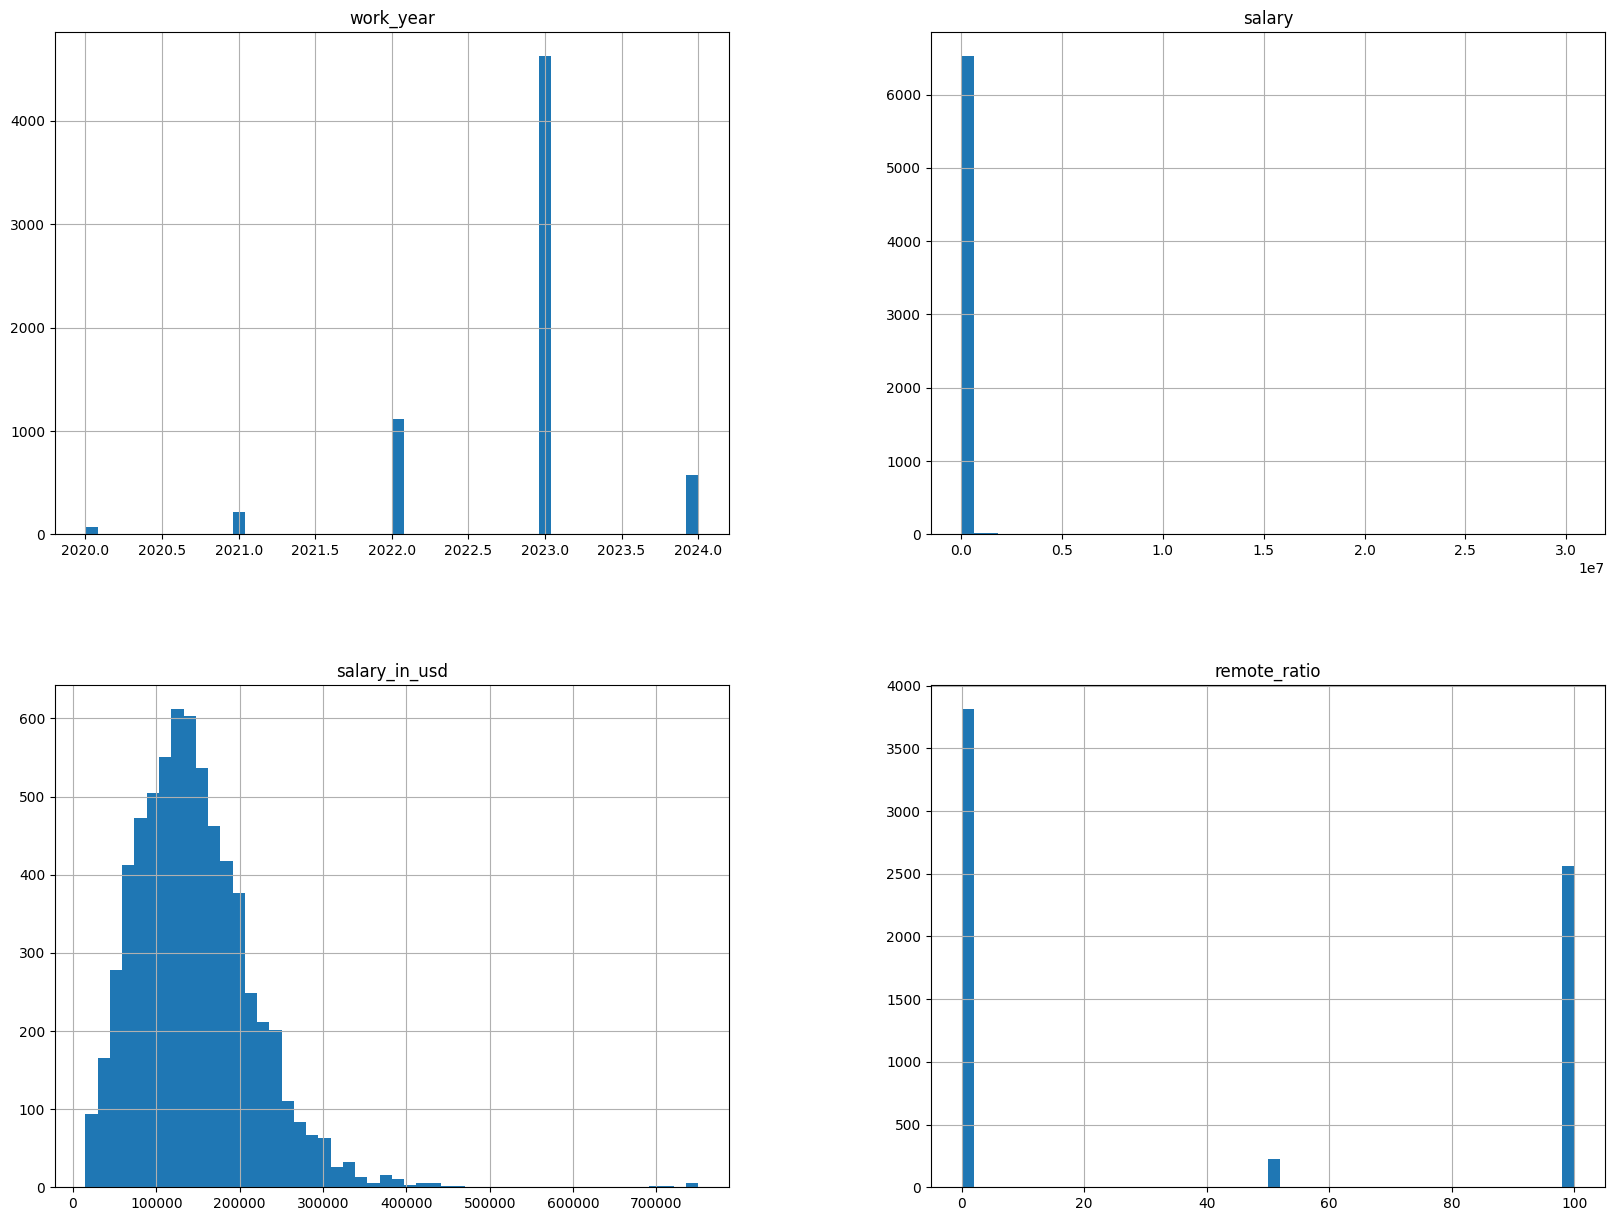

In [17]:
ds_jobs.hist(bins=50, figsize=(20,15))

`From the histogram, we can see that:
- all attributes are highly skewed, we may will transform it to have more gaussian bell curve shaped later.
- These attributes have very different scale, we will scale the values.
- Salary attribute seems have very wide range of values, maybe because it represents values in many different counrty cucrency. So we wil ignore this value and use only salary_in_usd. 

## 2. Create a Test Set
As experience_level has high contribution on target, we want to separate y with same proportion sampling based on experience_level.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(ds_jobs, ds_jobs['experience_level']):
    strat_train_set = ds_jobs.iloc[train_index]
    strat_test_set = ds_jobs.iloc[test_index]

## Discover and Visualize the Data to Gain Insights

In [19]:
ds_jobs = strat_train_set.copy()

In [20]:
ds_jobs.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size,remote_ratio
1785,Data Scientist,SE,FT,On-site,2023,US,111000,USD,111000,US,M,0
3974,Research Engineer,MI,FT,On-site,2023,US,200000,USD,200000,US,M,0
4928,AI Scientist,MI,FT,Hybrid,2023,Spain,36000,EUR,38868,Spain,L,50
4170,Data Science Consultant,MI,FT,On-site,2023,US,70000,USD,70000,US,M,0
2492,Business Intelligence Analyst,SE,FT,On-site,2023,US,99000,USD,99000,US,M,0


### Visualize Attributes

In [21]:
work_year_count = ds_jobs.work_year.value_counts().sort_index()
work_year_count

work_year
2020      50
2021     147
2022     784
2023    3234
2024     404
Name: count, dtype: int64

Text(0.5, 1.0, 'Num of Salary Records per Year')

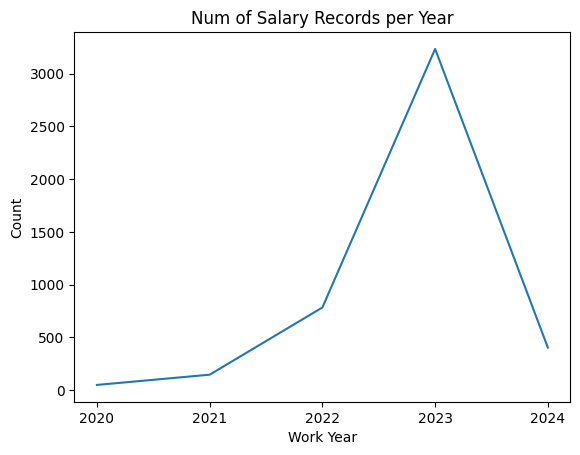

In [22]:
plt.plot(work_year_count.index, work_year_count)
plt.xlabel('Work Year')
plt.ylabel('Count')
plt.xticks(work_year_count.index)
plt.title('Num of Salary Records per Year')

We can see that data science jobs started booming in recent years.

Text(0.5, 1.0, 'Work Year Salary Distribution')

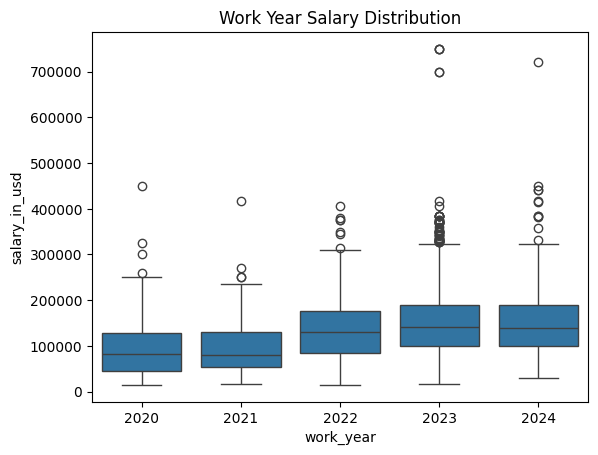

In [23]:
sns.boxplot(x='work_year', y='salary_in_usd', data=ds_jobs)
plt.title('Work Year Salary Distribution')

Text(0.5, 1.0, 'Work Year Salary Distribution')

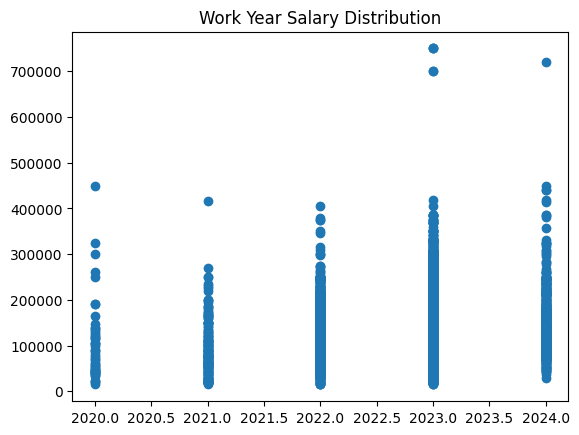

In [24]:
plt.scatter(x='work_year', y='salary_in_usd', data=ds_jobs)
plt.title('Work Year Salary Distribution')

Salary is increasing as year increases.

Text(0.5, 1.0, 'Experience Level Salary Distribution')

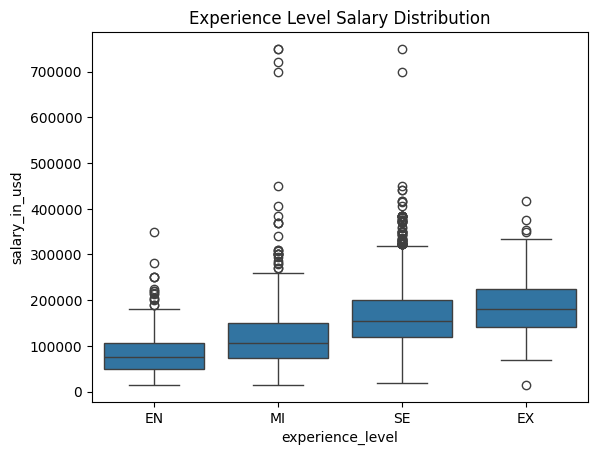

In [25]:
sns.boxplot(x='experience_level', y='salary_in_usd', data=ds_jobs, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Experience Level Salary Distribution')

The plot shows increasing order of salary as the experince level gets higher.

In [26]:
ds_jobs.employment_type.value_counts()

employment_type
FT    4586
CT      14
PT      10
FL       9
Name: count, dtype: int64

In [27]:
fulltime_salary = ds_jobs[ds_jobs.employment_type=='FT']['salary_in_usd'].mean()
non_fulltime_salary = ds_jobs[ds_jobs.employment_type!='FT']['salary_in_usd'].mean()

print(f'Fulltime salary: {fulltime_salary}')
print(f'Non Fulltime salary: {non_fulltime_salary}')

Fulltime salary: 146854.573920628
Non Fulltime salary: 83789.93939393939


Most employees have fulltime job and other types have small presence. Fulltime job also have higher paying than not. 

So later we want to preprocess employment_type into just two values: fulltime or not.

In [28]:
ds_jobs.job_title.unique()

array(['Data Scientist', 'Research Engineer', 'AI Scientist',
       'Data Science Consultant', 'Business Intelligence Analyst',
       'Research Analyst', 'Data Analyst', 'Data Engineer',
       'Data Modeler', 'Business Intelligence Developer',
       'Machine Learning Engineer', 'Data Manager', 'Data Architect',
       'AI Architect', 'Data Specialist', 'Data Quality Analyst',
       'ETL Developer', 'Principal Data Scientist',
       'Computer Vision Engineer', 'BI Analyst', 'Research Scientist',
       'Business Data Analyst', 'Lead Data Scientist',
       'AI Research Engineer', 'BI Developer',
       'Machine Learning Scientist', 'Head of Data',
       'Machine Learning Researcher', 'Data Operations Specialist',
       'Director of Data Science', 'AI Engineer', 'ML Engineer',
       'Applied Machine Learning Engineer', 'Data Science Manager',
       'Machine Learning Operations Engineer', 'Data Analytics Engineer',
       'Data Analytics Manager', 'MLOps Engineer', 'Data Strateg

There are many different values in job_title that actually share similar meaning. So later, I want to combine job_title with similar meaning into one like : Data Analyst, Data scientist, Data engineer, Machine learning engineer, AI engineer

In [29]:
ds_jobs.salary_currency.value_counts()

salary_currency
USD    4075
GBP     237
EUR     207
INR      34
CAD      26
AUD       8
PLN       6
SGD       5
CHF       4
BRL       3
JPY       3
THB       2
HUF       2
DKK       2
TRY       2
MXN       1
HKD       1
ILS       1
Name: count, dtype: int64

In [30]:
usd_currency = ds_jobs[ds_jobs.salary_currency=='USD']['salary_in_usd'].mean()
non_usd_currency = ds_jobs[ds_jobs.salary_currency!='USD']['salary_in_usd'].mean()

print(f'usd_currency: {usd_currency}')
print(f'Non usd_currency: {non_usd_currency}')

usd_currency: 155814.5626993865
Non usd_currency: 75911.39889705883


Most of currency is in USD, while some currency have very small occurrence. USD currency also have higher paying than not. 

So later we want to preprocess salary_currency into just two values: usd or not.

Text(0.5, 1.0, 'Salary Distributions')

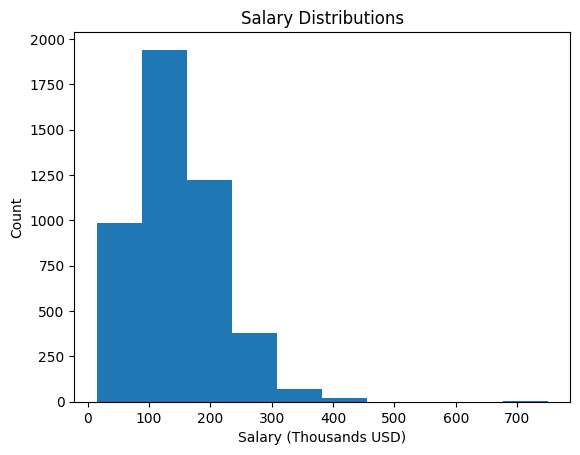

In [31]:
salary_usd_in_k = ds_jobs.salary_in_usd /1000

plt.hist(salary_usd_in_k)
plt.xlabel('Salary (Thousands USD)')
plt.ylabel('Count')
plt.title('Salary Distributions')

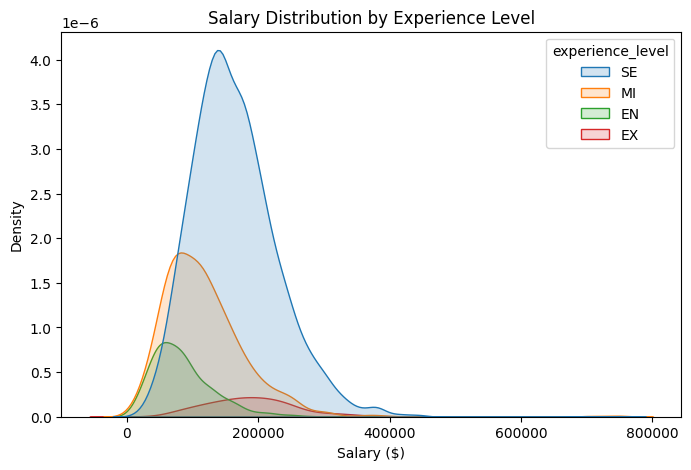

In [32]:
# Plot density
plt.figure(figsize=(8, 5))
sns.kdeplot(data=ds_jobs, x="salary_in_usd", hue="experience_level", fill=True, alpha=0.2)

# Labels
plt.xlabel("Salary ($)")
plt.ylabel("Density")
plt.title("Salary Distribution by Experience Level")
plt.show()

Salary is highly correlated with experience level of employee.

In [33]:
ds_jobs.employee_residence.value_counts()

employee_residence
US                3691
United Kingdom     289
Canada             172
Germany             50
India               48
                  ... 
Andorra              1
Jersey               1
Israel               1
Cyprus               1
Kuwait               1
Name: count, Length: 76, dtype: int64

In [34]:
us_employee_residence = ds_jobs[ds_jobs.employee_residence=='US']['salary_in_usd'].mean()
non_us_employee_residence = ds_jobs[ds_jobs.employee_residence!='US']['salary_in_usd'].mean()

print(f'us_employee_residence: {us_employee_residence}')
print(f'Non us_employee_residence: {non_us_employee_residence}')

us_employee_residence: 158813.22514223788
Non us_employee_residence: 97047.9849137931


Mpst of employess live in US, mostly employees are in Europe like UK, Spanyol, German. Outside that have small counts.

US employee residence also have higher paying than not. 

So later we want to preprocess employee_residence into just two values: us or not.

In [35]:
ds_jobs.groupby('remote_ratio').agg(
    count_remote_type= ('salary_in_usd', 'count'),
    avg_remote_type = ('salary_in_usd', 'mean')
)

,count_remote_type,avg_remote_type
remote_ratio,,
0,2669,152972.678157
50,157,81156.031847
100,1793,142339.413832


The salary relatively same for either fulltime or remote.

In [36]:
ds_jobs.company_location.value_counts()

company_location
US                3725
United Kingdom     294
Canada             173
Germany             59
France              40
                  ... 
Bahamas              1
Qatar                1
Andorra              1
China                1
Malaysia             1
Name: count, Length: 67, dtype: int64

In [37]:
us_company_location = ds_jobs[ds_jobs.company_location=='US']['salary_in_usd'].mean()
non_us_company_location = ds_jobs[ds_jobs.company_location!='US']['salary_in_usd'].mean()

print(f'us_company_location: {us_company_location}')
print(f'Non us_company_location: {non_us_company_location}')

us_company_location: 158160.25127516777
Non us_company_location: 97419.69574944071


Most companies are also based in US. US company also give higher salary than not.

So later we want to preprocess company_location into just two values: us or not.

<Axes: xlabel='company_size', ylabel='salary_in_usd'>

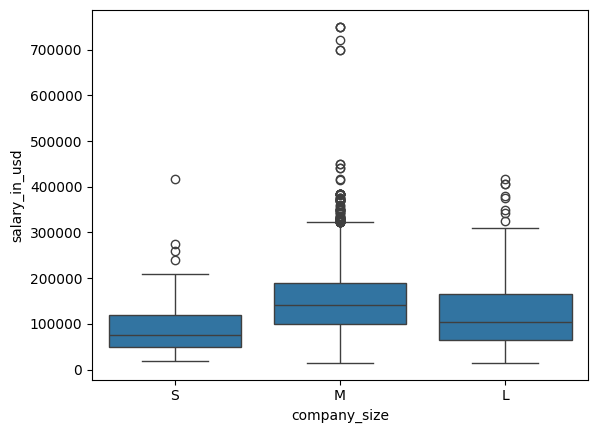

In [38]:
sns.boxplot(x='company_size', y='salary_in_usd', data=ds_jobs, order=['S', 'M', 'L'])

The size of company contirbutes to the salary ranges. Large companies tend to give higher salary

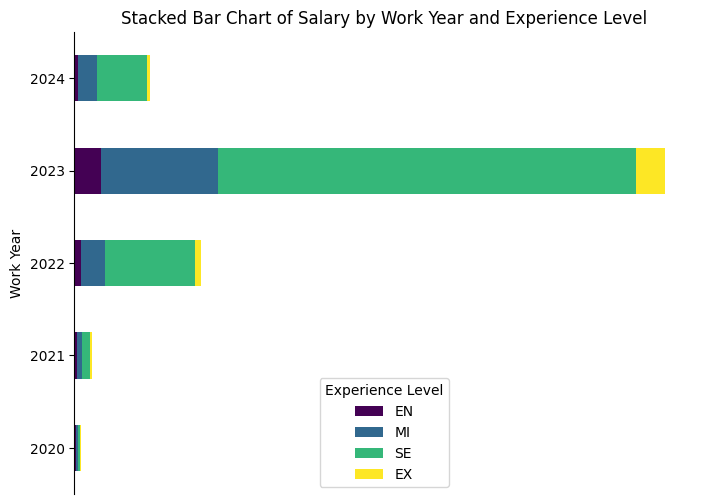

In [39]:
pivot_df = ds_jobs.pivot_table(values='salary_in_usd', index='work_year', columns='experience_level', aggfunc='sum', fill_value=0)

experience_order = ['EN', 'MI', 'SE', 'EX']
pivot_df = pivot_df[experience_order]

ax = pivot_df.plot(kind='barh', stacked=True, colormap="viridis", figsize=(8, 6))

plt.ylabel("Work Year")
plt.xlabel("Salary in USD")
plt.title("Stacked Bar Chart of Salary by Work Year and Experience Level")
plt.legend(title="Experience Level", loc='lower center')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)  
ax.xaxis.set_visible(False)  

plt.show()



Data Science and AI jobs mostly dominated by senior level experience.

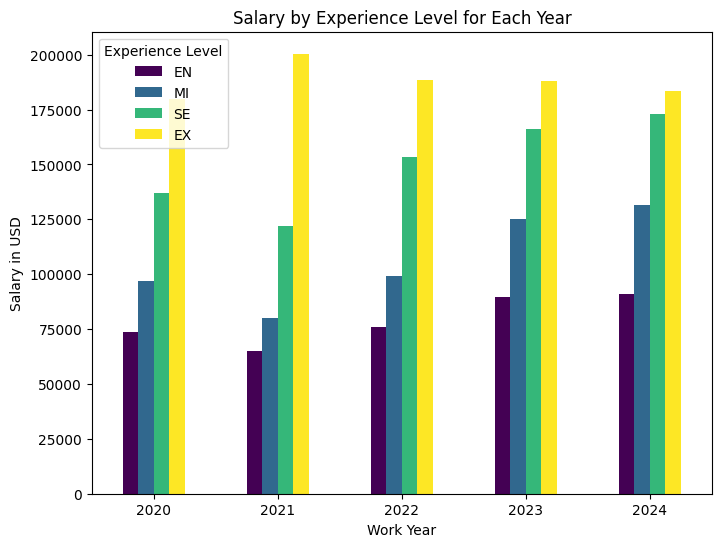

In [40]:
pivot_df = ds_jobs.pivot_table(values='salary_in_usd', index='work_year', columns='experience_level', aggfunc='mean', fill_value=0)

experience_order = ['EN', 'MI', 'SE', 'EX']
pivot_df = pivot_df[experience_order]

ax = pivot_df.plot(kind='bar', colormap="viridis", figsize=(8, 6))

plt.xlabel("Work Year")
plt.ylabel("Salary in USD")
plt.title("Salary by Experience Level for Each Year")
plt.legend(title="Experience Level")
plt.xticks(rotation=0)

plt.show()



Salary relatively increasing by year, but the salary for each level experience have similar range.

## 3. Check Outliers

Check outliers in salary by Experience_Level

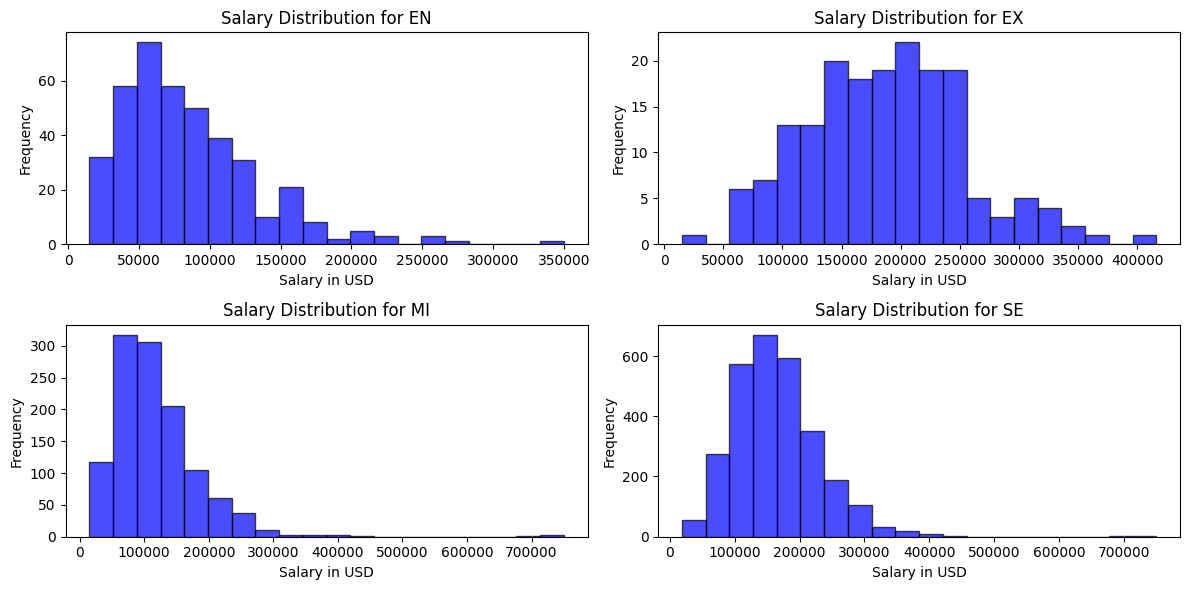

In [41]:
def plot_histogram_salary_of_experience(df):
    experience_levels = df['experience_level'].unique()
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))  # Create a 2x2 grid

    axes = axes.flatten()  

    for i, (exp, exp_salary_df) in enumerate(df.groupby('experience_level')):
        axes[i].hist(exp_salary_df.salary_in_usd, bins=20, alpha=0.7, color='blue', edgecolor='black')
        axes[i].set_title(f'Salary Distribution for {exp}')
        axes[i].set_xlabel('Salary in USD')
        axes[i].set_ylabel('Frequency')

    # Hide any unused subplots if less than 4 experience levels exist
    for j in range(i + 1, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

plot_histogram_salary_of_experience(ds_jobs)

In [42]:
def remove_outlier_salary(df):
    df_out = pd.DataFrame()
    for exp, exp_df in df.groupby('experience_level'):
        mean = np.mean(exp_df['salary_in_usd'])
        std = np.std(exp_df['salary_in_usd'])
        exp_df = exp_df[(exp_df['salary_in_usd'] >= (mean-2*std)) & (exp_df['salary_in_usd'] <= (mean+2*std))]
        df_out = pd.concat([df_out, exp_df])
    return df_out


In [43]:
cleaned_dsjobs = remove_outlier_salary(ds_jobs)
cleaned_dsjobs.shape

(4451, 12)

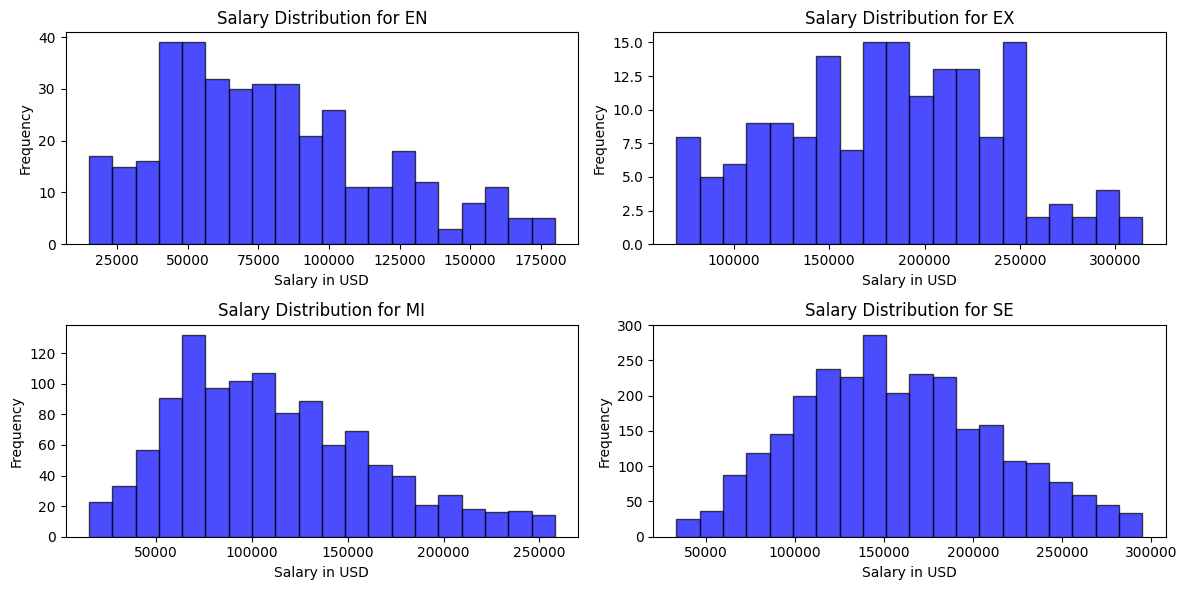

In [44]:
plot_histogram_salary_of_experience(cleaned_dsjobs)

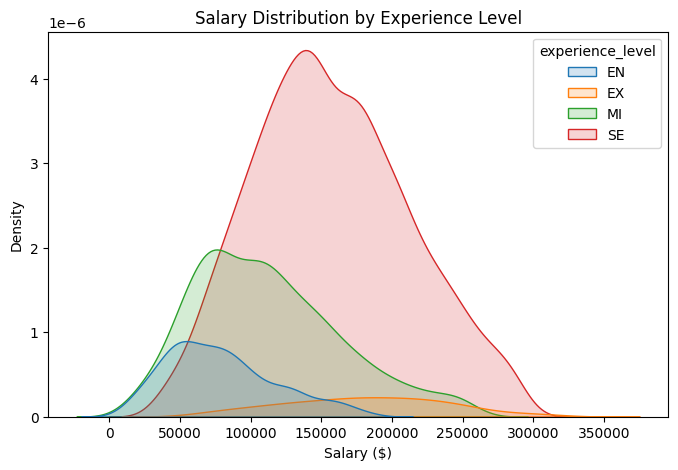

In [45]:
# Plot density
plt.figure(figsize=(8, 5))
sns.kdeplot(data=cleaned_dsjobs, x="salary_in_usd", hue="experience_level", fill=True, alpha=0.2)

# Labels
plt.xlabel("Salary ($)")
plt.ylabel("Density")
plt.title("Salary Distribution by Experience Level")
plt.show()

## 3. Data Wrangling

In [46]:
cleaned_dsjobs.isnull().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
remote_ratio          0
dtype: int64

In [47]:
# from sklearn.preprocessing import OrdinalEncoder

# year_encoder = OrdinalEncoder()

# year_encoder.fit_transform(cleaned_dsjobs[['work_year']])

In [48]:
# encode categorical values into number

def encode_categorical_values(df):
    df = df.copy()
    
    # Encode ordinal categorical features
    df['experience_level'] = df['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
    df['company_size'] = df['company_size'].replace({'S': 1, 'M': 2, 'L': 3})

    # Trim spaces from employment type
    df['employment_type'] = df['employment_type'].str.strip()
    
    # Convert binary categorical features
    df['fulltime_emp'] = (df['employment_type'] == 'FT').astype(int)
    df['us_currency'] = (df['salary_currency'] == 'USD').astype(int)
    df['us_emp_residence'] = (df['employee_residence'] == 'US').astype(int)
    df['us_company_loc'] = (df['company_location'] == 'US').astype(int)

    return df


df2 = encode_categorical_values(cleaned_dsjobs)
df2.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_14348\715554084.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['experience_level'] = df['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
C:\Users\Asus\AppData\Local\Temp\ipykernel_14348\715554084.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['company_size'] = df['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size,remote_ratio,fulltime_emp,us_currency,us_emp_residence,us_company_loc
4765,Research Analyst,1,FT,On-site,2023,United Kingdom,35000,GBP,43064,United Kingdom,2,0,1,0,0,0
1043,Data Analyst,1,FT,Remote,2023,US,102000,USD,102000,US,2,100,1,1,1,1
1566,Data Scientist,1,PT,On-site,2023,US,133000,USD,133000,US,2,0,0,1,1,1
1574,Research Analyst,1,FT,Remote,2023,US,43500,USD,43500,US,2,100,1,1,1,1
837,Data Manager,1,FT,On-site,2023,US,85600,USD,85600,US,2,0,1,1,1,1


In [49]:
# check job title values

job_title = df2.job_title.unique()
job_title

array(['Research Analyst', 'Data Analyst', 'Data Scientist',
       'Data Manager', 'Data Engineer', 'Data Science Consultant',
       'Business Data Analyst', 'Data Quality Analyst',
       'AI Research Engineer', 'AI Programmer', 'Big Data Engineer',
       'Machine Learning Scientist', 'Data Integration Specialist',
       'Computer Vision Engineer', 'Applied Machine Learning Scientist',
       'Data Quality Engineer', 'Computer Vision Software Engineer',
       'Applied Scientist', 'Machine Learning Engineer', 'AI Engineer',
       'ML Engineer', 'BI Data Analyst', 'Product Data Analyst',
       'Machine Learning Developer', 'Research Engineer',
       'Data Analyst Lead', 'Business Intelligence Analyst',
       'Cloud Data Engineer', 'Data Specialist',
       'Data Analytics Engineer', 'Applied Data Scientist',
       'Data Developer', 'Staff Data Analyst', 'Azure Data Engineer',
       'AI Scientist', 'BI Analyst', 'AI Developer', 'Research Scientist',
       'Financial Data Anal

In [50]:
len(job_title)

126

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

job_titles = df2["job_title"].tolist()
categories = ['AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
       'Data Scientist', 'Data Analyst/Data Specialist', 'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
       'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect', 'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer']

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(job_titles + categories)

job_vectors = vectors[: len(job_titles)]
category_vectors = vectors[len(job_titles) :]

similarities = cosine_similarity(job_vectors, category_vectors)
df3 = df2.copy()
df3["category"] = [categories[i] for i in similarities.argmax(axis=1)]
df3["similarities"] = similarities.max(axis=1) 

df3.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size,remote_ratio,fulltime_emp,us_currency,us_emp_residence,us_company_loc,category,similarities
4765,Research Analyst,1,FT,On-site,2023,United Kingdom,35000,GBP,43064,United Kingdom,2,0,1,0,0,0,Data Analyst/Data Specialist,0.232118
1043,Data Analyst,1,FT,Remote,2023,US,102000,USD,102000,US,2,100,1,1,1,1,Data Analyst/Data Specialist,0.552136
1566,Data Scientist,1,PT,On-site,2023,US,133000,USD,133000,US,2,0,0,1,1,1,Data Scientist,1.000000
1574,Research Analyst,1,FT,Remote,2023,US,43500,USD,43500,US,2,100,1,1,1,1,Data Analyst/Data Specialist,0.232118
837,Data Manager,1,FT,On-site,2023,US,85600,USD,85600,US,2,0,1,1,1,1,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.197454


In [52]:
df3[['job_title', 'category', 'similarities']].drop_duplicates()

,job_title,category,similarities
4765,Research Analyst,Data Analyst/Data Specialist,0.232118
1043,Data Analyst,Data Analyst/Data Specialist,0.552136
1566,Data Scientist,Data Scientist,1.000000
837,Data Manager,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.197454
6038,Data Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.451241
...,...,...,...
6596,Machine Learning Manager,Computer Vision/NLP/Deep Learning/Machine Lear...,0.275299
6139,Marketing Data Analyst,Data Analyst/Data Specialist,0.194568
6308,Staff Machine Learning Engineer,Computer Vision/NLP/Deep Learning/Machine Lear...,0.235418
5211,Manager Data Management,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.106228


In [53]:
df3.loc[df3.similarities <0.2][['job_title', 'category', 'similarities']].drop_duplicates().sample(5)

,job_title,category,similarities
4517,Compliance Data Analyst,Data Analyst/Data Specialist,0.180808
4265,Data Infrastructure Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.161476
4914,Principal Data Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.144589
6525,Managing Director Data Science,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.161650
2167,Financial Data Analyst,Data Analyst/Data Specialist,0.188627


In [54]:
df3.loc[(df3.similarities >0.2) & (df3.similarities <0.5)][['job_title', 'category', 'similarities']].drop_duplicates().sort_values(by='similarities')

,job_title,category,similarities
6594,Staff Data Analyst,Data Analyst/Data Specialist,0.203556
6414,Head of Data,Tech/Technical/IT Lead/Head/Director/Manager/S...,0.209292
1381,Machine Learning Researcher,Computer Vision/NLP/Deep Learning/Machine Lear...,0.210359
1722,Data Management Analyst,Data Analyst/Data Specialist,0.213339
4995,Data Science Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.217063
3797,AWS Data Architect,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.217562
1727,Machine Learning Modeler,Computer Vision/NLP/Deep Learning/Machine Lear...,0.221208
6283,Principal Data Analyst,Data Analyst/Data Specialist,0.222981
6061,Data Analytics Engineer,Data Architect/ Data ETL Cloud Engineer/ Data ...,0.224135
509,Data Quality Analyst,Data Analyst/Data Specialist,0.228780


In [55]:
df4 = df3[df3.similarities > 0.2]

In [56]:
for category in categories:
    print(category)
    print(df4.loc[df4.category == category]['job_title'].unique())
    print()

AI Engineer
['AI Research Engineer' 'AI Programmer' 'AI Engineer' 'AI Scientist'
 'AI Developer' 'AI Architect' 'AI Product Manager']

Data Architect/ Data ETL Cloud Engineer/ Data Engineer
['Data Engineer' 'Cloud Data Engineer' 'Data Analytics Engineer'
 'Data Science Engineer' 'Data Architect' 'AWS Data Architect'
 'ETL Developer' 'ETL Engineer' 'Big Data Architect'
 'Cloud Data Architect' 'Principal Data Architect'
 'Cloud Database Engineer']

Data Scientist
['Data Scientist' 'Machine Learning Scientist'
 'Applied Machine Learning Scientist' 'Applied Scientist'
 'Applied Data Scientist' 'Research Scientist' 'Data Scientist Lead'
 'Decision Scientist' 'Lead Data Scientist' 'Principal Data Scientist'
 'Marketing Data Scientist' 'Staff Data Scientist']

Data Analyst/Data Specialist
['Research Analyst' 'Data Analyst' 'Data Quality Analyst'
 'Data Integration Specialist' 'Product Data Analyst' 'Data Analyst Lead'
 'Data Specialist' 'Staff Data Analyst' 'Data Management Analyst'
 'Data Op

In [57]:
df4.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size,remote_ratio,fulltime_emp,us_currency,us_emp_residence,us_company_loc,category,similarities
4765,Research Analyst,1,FT,On-site,2023,United Kingdom,35000,GBP,43064,United Kingdom,2,0,1,0,0,0,Data Analyst/Data Specialist,0.232118
1043,Data Analyst,1,FT,Remote,2023,US,102000,USD,102000,US,2,100,1,1,1,1,Data Analyst/Data Specialist,0.552136
1566,Data Scientist,1,PT,On-site,2023,US,133000,USD,133000,US,2,0,0,1,1,1,Data Scientist,1.000000
1574,Research Analyst,1,FT,Remote,2023,US,43500,USD,43500,US,2,100,1,1,1,1,Data Analyst/Data Specialist,0.232118
6374,Data Scientist,1,FT,Hybrid,2021,US,58000,USD,58000,US,3,50,1,1,1,1,Data Scientist,1.000000


In [58]:
def cluster_job_title(df):
    X = df.copy()
        
    job_titles = X["job_title"].tolist()
    categories = ['AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
               'Data Scientist', 'Data Analyst/Data Specialist', 'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
               'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect', 'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer']

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(job_titles + categories)

    job_vectors = vectors[: len(job_titles)]
    category_vectors = vectors[len(job_titles) :]

    similarities = cosine_similarity(job_vectors, category_vectors)
        
        
    X["category"] = [categories[i] for i in similarities.argmax(axis=1)]
    X["similarities"] = similarities.max(axis=1) 
        
    X = X[X.similarities > 0.2]

    X.category = X.category.replace({
            'Data Analyst/Data Specialist': 'Data Analyst',
            'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
            'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
            'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
            'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
        })
    X.drop('job_title', axis=1, inplace=True)
    X.rename(columns={"category": "job_title"}, inplace=True)
        
return X

In [59]:
df4.shape

(3780, 18)

In [60]:
df5 = df4.copy()

df5.category = df5.category.replace({
    'Data Analyst/Data Specialist': 'Data Analyst',
    'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
    'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
    'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
    'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
})

df5.category.unique()

array(['Data Analyst', 'Data Scientist', 'Data Engineer',
       'Business Intelligence Specialist', 'AI Engineer',
       'Machine Learning Engineer', 'Software Engineer', 'IT Manager'],
      dtype=object)

In [61]:
job_title_stats = df5.groupby('category').agg(
    count_job_title = ('category', 'count'),
    avg_salary_job_title = ('salary_in_usd', 'mean')
).sort_values(by='avg_salary_job_title')

job_title_stats

,count_job_title,avg_salary_job_title
category,,
Data Analyst,760,104130.046053
Business Intelligence Specialist,207,115918.342995
AI Engineer,67,126016.417910
Data Engineer,1077,141284.231198
Software Engineer,12,144105.583333
Data Scientist,1100,151487.573636
IT Manager,36,155545.500000
Machine Learning Engineer,521,163988.545106


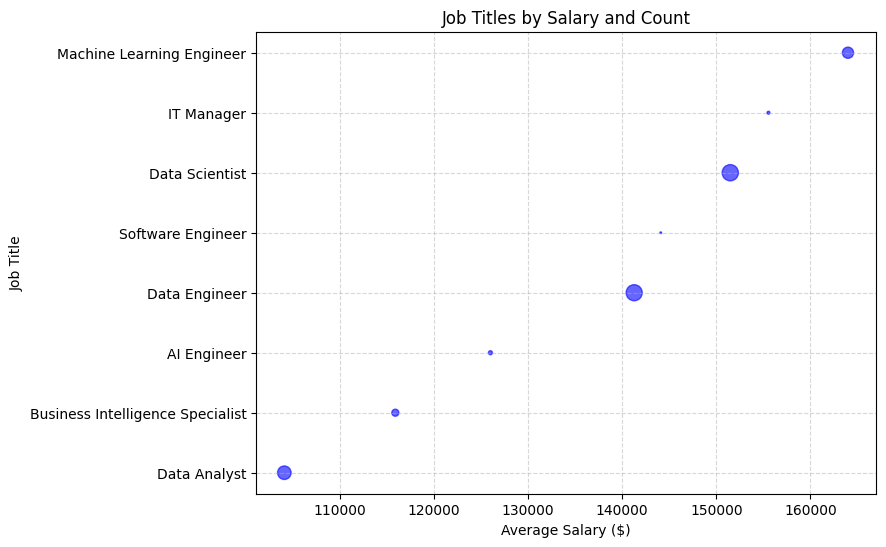

In [62]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    job_title_stats["avg_salary_job_title"], job_title_stats.index, 
    s=job_title_stats["count_job_title"] / 8,  # Scale bubble size
    alpha=0.6, color="blue"
)

plt.xlabel("Average Salary ($)")
plt.ylabel("Job Title")
plt.title("Job Titles by Salary and Count")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

The graph above shows salary difference for each job titles, with the size of bubbles reperesnt the count of job titles. 

We can see from the graph that machine learning field has the highest salary than others like data and AI.

In [63]:
# encode job titles
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
job_title_hot = cat_encoder.fit_transform(df5[['category']])
job_title_hot.toarray()


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [64]:
cat_encoder.categories_

[array(['AI Engineer', 'Business Intelligence Specialist', 'Data Analyst',
        'Data Engineer', 'Data Scientist', 'IT Manager',
        'Machine Learning Engineer', 'Software Engineer'], dtype=object)]

In [65]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cluster_job_title(df):
    df = df.copy()  # Ensure we don't modify the original DataFrame
    
    job_titles = df["job_title"].tolist()
    categories = [
        'AI Engineer', 'Data Architect/ Data ETL Cloud Engineer/ Data Engineer',
        'Data Scientist', 'Data Analyst/Data Specialist',
        'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer',
        'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect',
        'Tableau/BI Analyst/ Business Intelligence Specialist', 'Software Engineer'
    ]

    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(job_titles + categories)

    job_vectors = vectors[: len(job_titles)]
    category_vectors = vectors[len(job_titles) :]

    similarities = cosine_similarity(job_vectors, category_vectors)

    df["category"] = [categories[i] for i in similarities.argmax(axis=1)]
    df["similarities"] = similarities.max(axis=1) 

    df = df[df["similarities"] > 0.2]

    df["category"] = df["category"].replace({
        'Data Analyst/Data Specialist': 'Data Analyst',
        'Data Architect/ Data ETL Cloud Engineer/ Data Engineer': 'Data Engineer',
        'Computer Vision/NLP/Deep Learning/Machine Learning Engineer/ MLOps Engineer': 'Machine Learning Engineer',
        'Tableau/BI Analyst/ Business Intelligence Specialist': 'Business Intelligence Specialist',
        'Tech/Technical/IT Lead/Head/Director/Manager/Solutions Architect': 'IT Manager'
    })

    df.drop('job_title', axis=1, inplace=True)
    df.rename(columns={"category": "job_title"}, inplace=True)
    
    return df


In [66]:
clustered_cleaned_dsjobs = cluster_job_title(cleaned_dsjobs)

### Creating Preparation Pipeline
my processing

a. Target column
- remove target outliers

b. num features
 - numeric: standard scaler
 - time year: ordinal encoder

c. Cat features
- mapping w/ custom transformer 

c. job titles column
- cluster job titles
- onehotencode job titles


#### Creating  Custom Transformers

In [71]:
from pipeline import CatAttrEncoder

cat_encoder = CatAttrEncoder()
ds_jobs_encoded = cat_encoder.fit_transform(cleaned_dsjobs)
ds_jobs_encoded.sample(3)

D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


,experience_level,company_size,fulltime_emp,us_currency,us_emp_residence,us_company_loc
273,3,2,1,1,1,1
6506,2,3,1,0,0,0
515,2,2,1,0,0,0


In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [75]:
# separate X and y values before applying transformation

jobs = clustered_cleaned_dsjobs.drop(['salary', 'salary_in_usd'], axis=1)
jobs_labels = clustered_cleaned_dsjobs.salary_in_usd.copy()

In [76]:
from pipeline import CatAttrEncoder
from pipeline import time_num_pipeline

time_num_attribs = ['work_year']
cat_attribs = ['experience_level', 'employment_type', 'salary_currency',
               'employee_residence', 'company_location', 'company_size']
job_title_attribs = ['job_title']

# create column transformer pipeline to transform attribute values
feature_transformation_pipeline = ColumnTransformer([
    ("time_num", time_num_pipeline, time_num_attribs), # transform year col
    ("cat", CatAttrEncoder(), cat_attribs),
    ("job_title", OneHotEncoder(), job_title_attribs)
])



In [77]:
jobs_prepared = feature_transformation_pipeline.fit_transform(jobs)
jobs_prepared

D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


array([[0.28478353, 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28478353, 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28478353, 1.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28478353, 3.        , 2.        , ..., 0.        , 1.        ,
        0.        ],
       [0.28478353, 3.        , 2.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28478353, 3.        , 2.        , ..., 0.        , 0.        ,
        0.        ]])

In [78]:
jobs_prepared.shape

(3780, 15)

## Modelling

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(jobs_prepared, jobs_labels)

LinearRegression()

In [80]:
from sklearn.metrics import mean_squared_error

salary_predictions = lin_reg.predict(jobs_prepared)
lin_mse = mean_squared_error(jobs_labels, salary_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(45937.444680648274)

In [81]:
some_data = ds_jobs.iloc[:5]

cleaned_data = cluster_job_title(some_data)

some_data_X = some_data.drop('salary_in_usd', axis=1)
some_data_y = some_data.salary_in_usd.copy()

clustered_jobs_dataX = cluster_job_title(some_data_X)
some_data_prepared = feature_transformation_pipeline.transform(clustered_jobs_dataX)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [172489.62132418 138805.48124555  76673.74696231 103825.65923658
 139752.22302348]
Labels: [111000, 200000, 38868, 70000, 99000]


D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


In [82]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(jobs_prepared, jobs_labels)

salary_predictions = tree_reg.predict(jobs_prepared)
tree_mse = mean_squared_error(jobs_labels, salary_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(43164.9387464141)

In [83]:
print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [177856.10648148 155025.          60353.         100037.73333333
 142858.56      ]
Labels: [111000, 200000, 38868, 70000, 99000]


In [84]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(jobs_prepared, jobs_labels)

salary_predictions = forest_reg.predict(jobs_prepared)
forest_mse = mean_squared_error(jobs_labels, salary_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(43355.34128690463)

###  Better Evaluation Using Cross-Validation

In [85]:
from sklearn.model_selection import cross_val_score

In [86]:
## decision tree
scores = cross_val_score(tree_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [87]:
def display_scores(scores):
    print("Scores:", scores)   
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [88]:
display_scores(tree_rmse_scores)

Scores: [45987.42846855 50616.75144913 44306.15437168 43319.53537441
 47815.44505155 51968.14695172 46933.40458957 49515.00836962
 50186.97523959 47847.77493558]
Mean: 47849.66248013971
Standard deviation: 2650.324948227729


In [89]:
## linear regression
lin_scores = cross_val_score(lin_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [90]:
display_scores(lin_rmse_scores)

Scores: [41222.63023648 45908.88579196 42482.73970573 42641.92000773
 47210.07433059 51983.35476879 46299.10979595 48732.15671595
 48698.1844995  47786.24658929]
Mean: 46296.53024419762
Standard deviation: 3176.3173746895513


In [91]:
## random forest
forest_scores = cross_val_score(forest_reg, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [92]:
display_scores(forest_rmse_scores)

Scores: [44313.45981939 47560.91699506 42820.61155487 42833.14513029
 47606.42576347 51054.62335724 46518.62173221 48961.40979115
 49581.27779885 47775.27760955]
Mean: 46902.57695520832
Standard deviation: 2653.6353824370744


In [107]:
## ridge 
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge_scores = cross_val_score(ridge, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)

display_scores(ridge_rmse_scores)

Scores: [40986.83367408 45902.15081791 42496.00037405 42638.07954089
 47214.04628871 51970.41798623 46309.08146891 48729.85700262
 48702.74277177 47804.71053653]
Mean: 46275.39204616966
Standard deviation: 3212.363216956369


The best score achieved with Random Forest

## Fine-Tune Model

In [101]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Example: Ridge Regression
ridge = Ridge()
param_grid = {'alpha': [0.1, 0.5, 1, 2, 5, 10, 15, 20, 25, 50, 100]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(jobs_prepared, jobs_labels)

print("Best params:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)


Best params: {'alpha': 25}
Best RMSE: 46366.4533781962


In [108]:
## ridge 
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=25)
ridge_scores = cross_val_score(ridge, jobs_prepared, jobs_labels,
                         scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)

display_scores(ridge_rmse_scores)

Scores: [38804.14042489 45865.46982014 42615.45645115 42600.91457724
 47312.39183007 52050.81342199 46489.52185218 48773.58787748
 48831.25127269 48105.42051946]
Mean: 46144.89680472844
Standard deviation: 3651.2104208500295


Tuning Model improves base model performance

## Analyze Best Models

In [118]:
time_num_attribs = ["work_year"]
cat_attribs = ['experience_level', 'company_size', 'fulltime_emp', 'us_currency', 'us_emp_residence', 'us_company_loc']
job_title_encoder = feature_transformation_pipeline.named_transformers_["job_title"]
job_title_onehotencode_attribs = list(job_title_encoder.categories_[0])

attributes = time_num_attribs + cat_attribs + job_title_onehotencode_attribs

In [117]:
coefficients = grid_search.best_estimator_.coef_
feature_names = attributes
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
print(importance_df)


                             Feature   Coefficient
4                        us_currency  38006.315223
9                       Data Analyst -27969.252967
1                   experience_level  27619.493136
5                   us_emp_residence  21779.391072
13         Machine Learning Engineer  21718.464857
8   Business Intelligence Specialist -18354.023032
3                       fulltime_emp  12710.886961
11                    Data Scientist  12129.767066
12                        IT Manager   4633.435885
14                 Software Engineer   4294.961096
7                        AI Engineer   3941.466750
0                          work_year   2978.876402
6                     us_company_loc   1592.449567
2                       company_size   1224.580184
10                     Data Engineer   -394.819655


## Evaluate on Test Set

In [121]:
from sklearn.ensemble import RandomForestRegressor

data_cleaned = remove_outlier_salary(strat_train_set)
data_cleaned = cluster_job_title(data_cleaned)

data_X = data_cleaned.drop('salary_in_usd', axis=1)
data_y = data_cleaned.salary_in_usd.copy()

data_prepared = feature_transformation_pipeline.transform(data_X)

ridge = Ridge(alpha=25)
ridge.fit(data_prepared, data_y)

D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


Ridge(alpha=25)

In [122]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


final_model = ridge

test_set = cluster_job_title(strat_test_set)

X_test = test_set.drop('salary_in_usd', axis=1)
y_test = test_set['salary_in_usd'].copy()

X_test_prepared = feature_transformation_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f'RMSE: {final_rmse}')

mae = mean_absolute_error(y_test, final_predictions)
print(f'MAE: {mae}')

r2 = r2_score(y_test, final_predictions)
print(f'R squared: {r2}')

RMSE: 56496.70607193666
MAE: 40368.32480148696
R squared: 0.3204590572917546


D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


In [123]:
some_data = ds_jobs.iloc[:5]

some_data_cleaned = cluster_job_title(some_data)

some_data_X = some_data_cleaned.drop('salary_in_usd', axis=1)
some_data_y = some_data_cleaned.salary_in_usd

some_data_prepared = feature_transformation_pipeline.transform(some_data_X)

print("Predictions:", ridge.predict(some_data_prepared))
print("Labels:", list(some_data_y))

Predictions: [172191.04258603 136383.24913415  76229.6734559  104472.52941737
 141707.25248825]
Labels: [111000, 200000, 38868, 70000, 99000]


D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['experience_level'] = X['experience_level'].replace({'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4})
D:\projects\7_salary_prediction\DsJobSalaries\model\pipeline.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['company_size'] = X['company_size'].replace({'S': 1, 'M': 2, 'L': 3})


## Save Models

In [124]:
import pickle
with open('ds_jobs_salaries_model.pickle', 'wb') as f:
    pickle.dump(final_model, f)

In [125]:
import json
columns = {
    'data_columns' : [col for col in ds_jobs.columns if col not in ['salary_in_usd', 'salary']],
    'job_titles': job_title_onehotencode_attribs,
    'company_locations': ds_jobs.company_location.unique().tolist(),
    'currency': ds_jobs.salary_currency.unique().tolist(),
    'employee_residence': ds_jobs.employee_residence.unique().tolist(),
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [126]:
import joblib

# Assuming 'pipeline' is your trained model or preprocessing pipeline
joblib.dump(feature_transformation_pipeline, "feature_transformation_pipeline.pkl")

['feature_transformation_pipeline.pkl']